---
title: Bayes-ball part 2: a more realistic prior
toc: true
toc_sticky: true
---

I meant to post this some time ago, but I have been busy. But with the baseball example I am using, it is only fitting that I post this now, just after this year's strange timing of MLB's Opening Day. (My team had a [nice opening day win!](https://www.sandiegouniontribune.com/sports/padres/story/2020-07-24/padres-diamondbacks-chris-paddack-madison-bumgarner-eric-hosmer-opening-day))

In my last post, I applied Bayes' theorem towards revealing a hypothetical player's probability distribution for their hit rate after observing their performance for a given time. Essentially, we found the player's posterior distribution. However, because the priorwas a [Bernoulli distribution](https://brilliant.org/wiki/bernoulli-distribution/), so was the resulting posterior. This is not realistic. We would instead expect the distribution to *appear* Gaussian. (I emphasize "appear" for reasons you will see down below.) A Bernoulli distribution also does not really allow us to apply the concept of a [credible interval](https://en.wikipedia.org/wiki/Credible_interval). Going down this Bayesian rabbit hole, I became more interested in some of the concepts and went back through some old notes. I examine this question in a few posts. Here, let's focus on using a different, more realistic prior!

First, a few shout-outs to some sources I referenced when writing this post. 
- David Robinson already wrote a [superb post](http://varianceexplained.org/r/credible_intervals_baseball/) on credible intervals, which also happened to use baseball statistics.
- I also found [this useful reference from Carnegie Mellon Statistics](http://www.stat.cmu.edu/~brian/463-663/week09/Chapter%2003.pdf).
- I also looked back at a course I completed from Couresera, entitled [Bayesian Statistics: From Concept to Data Analysis](https://www.coursera.org/learn/bayesian-statistics).

In [3]:
# Load packages for coding examples
import pandas as pd
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import norm
sns.set_context('talk')   # visual theme

I won't restate the whole problem, but you can find it in the [previous post](https://benslack19.github.io/data%20science/statistics/b-bayes-ball/) if you need a reminder.

What if we weren't asking for a single probability if Aguila was in the 10% hit rate group versus the 25% hit group? What if we asked where Aguila's batting average (hitting rate) would be across a *range* of talent levels? Let's take these steps in a couple of iterations. First, let's take the original Bernoulli distribution example and show how the prior distribution gets updated with data to produce the posterior distribution. I show this differently than I did in the last post.

# Showing the posterior distribution results from the prior and the data

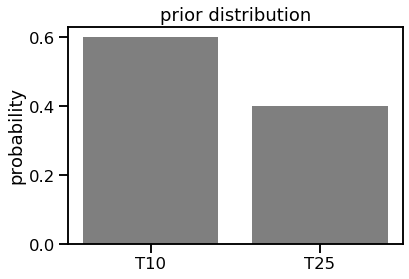

In [4]:
f, ax1 = plt.subplots()
ax1.bar([0, 1], [0.6, 0.4], color='k', alpha=0.5)
ax1.set_xticks([0,1])
ax1.set_xticklabels(['T10', 'T25'])
ax1.set_ylabel('probability')
ax1.set_title('prior distribution');

Now let's add in the data of 18 hits in 100 at-bats.

In [5]:
# T10 group
n, p10 = 100, 0.1
rv10 = binom(n, p10)

# T25 group
n, p25 = 100, 0.25
rv25 = binom(n, p25)

In [6]:
posterior_p10 = (rv10.pmf(18) * 0.6) / ((rv10.pmf(18) * 0.6) + (rv25.pmf(18) * 0.4))
posterior_p25 = (rv25.pmf(18) * 0.4) / ((rv10.pmf(18) * 0.6) + (rv25.pmf(18) * 0.4))
print("Posterior probability for T10 group: {0:0.4f}".format(posterior_p10))
print("Posterior probability for T25 group: {0:0.4f}".format(posterior_p25))

Posterior probability for T10 group: 0.2428
Posterior probability for T25 group: 0.7572


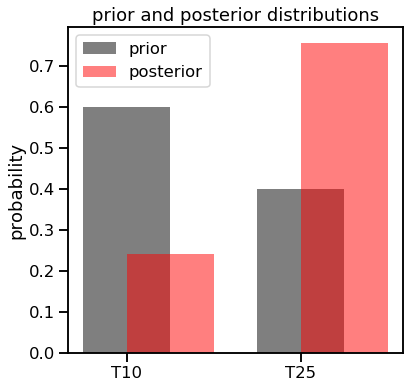

In [7]:
f, ax1 = plt.subplots(figsize=(6,6))
ax1.bar([0, 1], [0.6, 0.4], width=0.5, color='k', alpha=0.5, label='prior')
ax1.bar([0.25, 1.25], [posterior_p10, posterior_p25], width=0.5, color='r', alpha=0.5, label='posterior')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['T10', 'T25'])
ax1.set_ylabel('probability')
ax1.set_title('prior and posterior distributions')
ax1.legend();

Note how even though we calculated the posterior values for both, we could have easily just taken 1 - the probability of the T25 group. Now let's apply the same process but using a different, more realistic prior distribution.

# Using a more realistic prior: the beta distribution

I mentioned above how we'd expect the prior and resulting distributions to *appear* Gaussian. I started with a normal distribution as my prior but realized that this would not work. That is because the Gaussian is not "conjugate" to the binomial (the distribution of the data), meaning they're not in the same family. The math gets [wonky](https://media.giphy.com/media/VGVwLultLZjrrssAak/giphy.gif) if we try to multiply the data (the [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function)) with a prior that is not in the same family. [Here](https://www.johndcook.com/blog/conjugate_prior_diagram/) is nice diagram of related distributions. (We'll actually carry out this math in a later post.)

This [post](http://varianceexplained.org/statistics/beta_distribution_and_baseball/), also from David Robinson, helped me better understand the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) and how it could be used in this problem. The beta distribution is parameterized by $\alpha$ and $\beta$. Here is the probability density function (PDF) of the beta distribution

$\frac{x^{\alpha-1}(1-x)^{\beta-1}}{\mathrm{B}(\alpha,\beta)}\$

where

${\mathrm{B}(\alpha,\beta)} = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}$.

You can see that how looking at the numerator of the PDF how the beta distribution relates to Bernoulli and binomial distributions. One easy way to think about the beta distribution's parameters is that $\alpha$ represents the counts of "1's" and $\beta$ represents the counts of "0's".

To generate a prior, I need to set the values of $\alpha$ and $\beta$ but what should I choose? I decided to use some constraints of the original problem. Let's say that the true talent rates of 10% and 25% are not the *only* values we would consider, but instead we can say that they are the *bounds* of the prior and posterior distributions. This makes the mean straightforward to identify: we just take the midpoint between these two values.

In [8]:
# mu is the midpoint between the two talent rates of the original problem
mu = (.25-0.1)/2 + 0.1   
print("mu value: ", mu)

mu value:  0.175


However, as noted above, the mean itself is not a parameter of a beta distribution, but rather a result of it. We still need to choose $\alpha$ and $\beta$. Since the mean of a beta distribution is $\frac{\alpha}{\alpha + \beta}$, many values can theoretically work. For example, $\alpha$ and $\beta$ values of 3.5 and 16.4, respectively, but so can 175 and 825. Let's plot a few different values of $\alpha$ and $\beta$ that use this mean. (I'm limiting the x-axis limit of the plot to 0.5 for visibility purposes.)

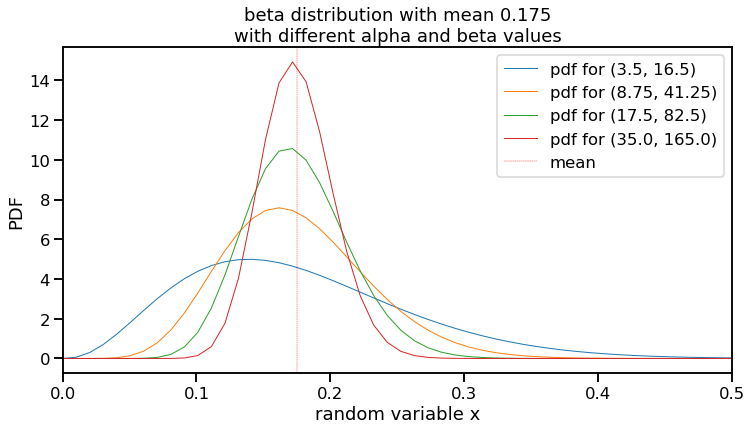

In [98]:
# Generate different values of alpha (a) and beta (b)
total_ab_list = [20, 50, 100, 200]

f, ax1 = plt.subplots(figsize=(12,6))
for total_ab in total_ab_list:
    #a = round(mu*total_ab)
    a = (mu*total_ab)
    b = total_ab-a

    x = np.linspace(beta.ppf(0.00, a, b),
                    beta.ppf(1.00, a, b), 100)
    this_label = 'pdf for (' + str(a) + ', ' + str(b) + ')'

    ax1.plot(x, beta.pdf(x, a, b),
             lw=1, label=this_label)
    
ax1.axvline(mu, lw=0.4, color='red', linestyle='dashed', label='mean')
ax1.set_title('beta distribution with mean 0.175\nwith different alpha and beta values')
ax1.set_xlim([0, 0.5])
ax1.set_xlabel('random variable x')
ax1.set_ylabel('PDF')
ax1.legend();

This visualization highlights a few things to note about the beta distribution examples.
1. These figures show distributions that are "Gaussian-like" and provides a range of realistic, true talent values that I sought. (I wondered about the differences and came across [this post](https://stats.stackexchange.com/questions/317729/is-the-gaussian-distribution-a-specific-case-of-the-beta-distribution).)
2. The values on the y-axis seem to go high. However, since this is a PDF, the area under each of these curves equals 1 and since the random variable (x-axis) is a fraction that is necessarily less than 1, the y-values are high to "compensate".
3. You can see that these different examples can all have the same mean, but can vary quite a bit in their maximum and where most of their distribution mass is located. The blue line is particularly different, with $\alpha$ and $\beta$ values of 3.5 and 16.5, shows it's peak at 0.141.
4. Related to point 3 is that as the values of $\alpha$ and $\beta$ increase, the variance gets tighter. This lines up with intuition. The more previous information you have, the less uncertain your prior would be. (In fact, after an experiment is performed, the resulting posterior distribution can be used as a prior for the next experiment.)

Therefore, we can consider where we want the majority of the prior distribution values to lie when setting $\alpha$ and $\beta$. I stated above that we would like the lower and upper bounds of our random variable x to be 0.10 and 0.25. We can define these bounds to contain the central 95% of the probability distribution and choose $\alpha$ and $\beta$ that way (along with the mean of 0.175 as we figured above). Therefore, we can get the values of the random variable x for the lower bound at 0.025 and the upper bound at 0.975 using the [quantile function](https://en.wikipedia.org/wiki/Quantile_function) by trying different $\alpha$ and $\beta$ values. This is called the **prior predictive interval**. We are predicting where we think the new data would lie.

In [18]:
# Generate different values of alpha (a) and beta (b)
total_ab_list = [25, 50, 75, 100, 125, 150, 200]
for total_ab in total_ab_list:
    # Get credible interval
    a = mu*total_ab
    b = total_ab-a
    print(beta.ppf([0.025, 0.975], a, b), total_ab, a, b)

[0.05601639 0.34279033] 25 4.375 20.625
[0.08394981 0.29058345] 50 8.75 41.25
[0.09829295 0.26808586] 75 13.125 61.875
[0.10738818 0.25490391] 100 17.5 82.5
[0.11382069 0.24601661] 125 21.875 103.125
[0.11868349 0.23951621] 150 26.25 123.75
[0.1256696  0.23048195] 200 35.0 165.0


We can see by looking at different values that an $\alpha$ and $\beta$ of 17.5 and 82.5 provide lower and upper bounds close to our desired values of 0.10 and 0.25.

As an aside, you may have noticed that the $\Gamma$ function was used as part of the equation when defining the PDF for the beta distribution. The $\Gamma$ function is often depicted as 
<br>
$\Gamma(n) = (n-1)!$
<br>
I then wondered how decimal values for $\alpha$ and $\beta$, as we have found here, could work in a factorial. It turns out that the [$\Gamma$ function](https://en.wikipedia.org/wiki/Gamma_function) extends what a factorial can do towards positive, non-integer values.)

Great! We now have the parameters for our prior. I will call this $\alpha_{0}$ and $\beta_{0}$ going forward (or a0 and b0 in code). Let's plot this on its own.

a0, b0 values:  17.5 82.5


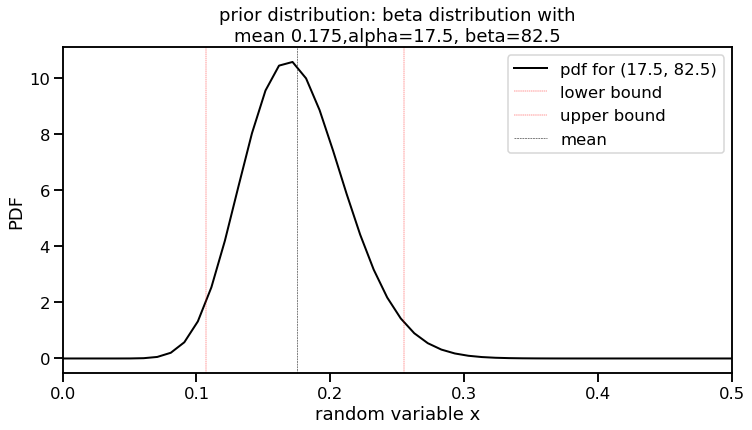

In [29]:
# Use a0 and b0 for our prior
total_ab = 100
a0 = mu*total_ab
b0 = total_ab-a0
print("a0, b0 values: ", a0, b0)

f, ax1 = plt.subplots(figsize=(12,6))

x = np.linspace(beta.ppf(0.000, a0, b0),
                beta.ppf(1.000, a0, b0), 100)
this_label = 'pdf for (' + str(a0) + ', ' + str(b0) + ')'
lower_bound, upper_bound = beta.ppf([0.025, 0.975], a0, b0)

ax1.plot(x, beta.pdf(x, a0, b0), color='black',
         lw=2, label=this_label)
    
ax1.axvline(lower_bound, lw=0.4, color='red', linestyle='dashed', label='lower bound')
ax1.axvline(upper_bound, lw=0.4, color='red', linestyle='dashed', label='upper bound')
ax1.axvline(mu, lw=0.5, color='black', linestyle='dashed', label='mean')
ax1.set_title('prior distribution: beta distribution with\nmean 0.175,alpha=17.5, beta=82.5')
ax1.set_xlim([0, 0.5])
ax1.set_xlabel('random variable x')
ax1.set_ylabel('PDF')
ax1.legend();

Awesome. We now have a more realistic prior. How will this impact our posterior once we add in the data? That will be in the next post. See you there!